In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_telco_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Tenure_Group
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0-12
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,25-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0-12
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,25-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0-12


## Which groups should we target with specific retention or upgrade offers to maximize long-term stability?

### Create Customer Segments

In [2]:
# Segment customers by demographics
# We create a new column 'Customer_Segment' combining SeniorCitizen + Partner + Dependents

df['Customer_Segment'] = df['SeniorCitizen'].astype(str) + '_' + df['Partner'] + '_' + df['Dependents']

df[['SeniorCitizen','Partner','Dependents','Customer_Segment']].head()


,SeniorCitizen,Partner,Dependents,Customer_Segment
0,0,Yes,No,0_Yes_No
1,0,No,No,0_No_No
2,0,No,No,0_No_No
3,0,No,No,0_No_No
4,0,No,No,0_No_No


### Analyze Churn per Segment

In [3]:
# Calculate churn count and percentage per segment
segment_churn = df.groupby('Customer_Segment')['Churn'].value_counts().unstack()
segment_churn_percent = segment_churn.div(segment_churn.sum(axis=1), axis=0) * 100

segment_churn_percent.round(1).sort_values(by='Yes', ascending=False).head(10)


Churn,No,Yes
Customer_Segment,,
1_No_No,50.8,49.2
1_Yes_No,63.7,36.3
0_No_No,68.8,31.2
1_No_Yes,75.0,25.0
1_Yes_Yes,75.9,24.1
0_No_Yes,78.6,21.4
0_Yes_No,79.2,20.8
0_Yes_Yes,86.2,13.8


### Check High-Value Customers

In [4]:
# Calculate average MonthlyCharges and TotalCharges per segment
segment_value = df.groupby('Customer_Segment')[['MonthlyCharges','TotalCharges']].mean().round(1)

# Combine with churn % for insight
segment_analysis = segment_churn_percent.join(segment_value)
segment_analysis.sort_values(by='Yes', ascending=False).head(10)


,No,Yes,MonthlyCharges,TotalCharges
Customer_Segment,,,,
1_No_No,50.802139,49.197861,76.9,2056.1
1_Yes_No,63.673469,36.326531,82.8,3480.8
0_No_No,68.848841,31.151159,60.1,1518.8
1_No_Yes,75.000000,25.000000,75.4,1991.6
1_Yes_Yes,75.903614,24.096386,83.0,4031.0
0_No_Yes,78.632479,21.367521,52.1,1335.1
0_Yes_No,79.191745,20.808255,71.7,3270.2
0_Yes_Yes,86.179843,13.820157,60.0,2682.6


### Services Usage Analysis

In [5]:
# See which services are used per segment
service_cols = ['InternetService','OnlineSecurity','OnlineBackup','TechSupport','StreamingTV','StreamingMovies']

# Group by segment and count
services_summary = df.groupby('Customer_Segment')[service_cols].agg(lambda x: (x=='Yes').sum())

# Join with churn % for deeper insight
retention_opportunity = segment_churn_percent.join(services_summary)
retention_opportunity.sort_values(by='Yes', ascending=False).head(10)


,No,Yes,InternetService,OnlineSecurity,OnlineBackup,TechSupport,StreamingTV,StreamingMovies
Customer_Segment,,,,,,,,
1_No_No,50.802139,49.197861,0,105,193,98,257,258
1_Yes_No,63.673469,36.326531,0,144,235,127,261,284
0_No_No,68.848841,31.151159,0,614,729,672,837,863
1_No_Yes,75.000000,25.000000,0,2,2,2,3,3
1_Yes_Yes,75.903614,24.096386,0,31,46,33,51,50
0_No_Yes,78.632479,21.367521,0,94,94,92,89,87
0_Yes_No,79.191745,20.808255,0,433,508,442,567,571
0_Yes_Yes,86.179843,13.820157,0,592,618,574,638,615


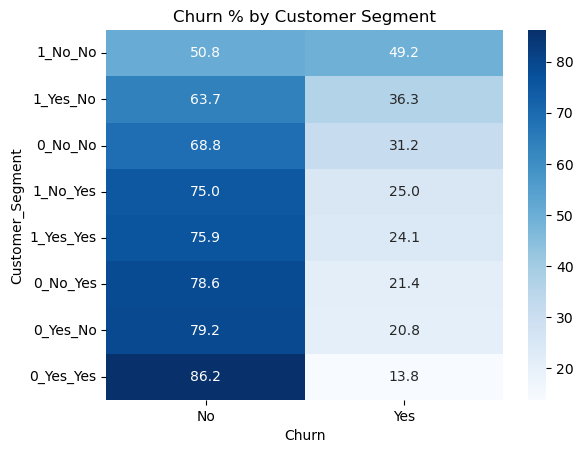

In [6]:
# Heatmap of churn % for top 10 segments
top_segments = segment_churn_percent.sort_values(by='Yes', ascending=False).head(10)
sns.heatmap(top_segments, annot=True, cmap='Blues', fmt='.1f')
plt.title('Churn % by Customer Segment')
plt.show()


### Insight:

Retention efforts should focus on long-term customers with partners or dependents who currently pay for premium services but lack technical support. These segments are high-value and at risk of churn.